In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

import scipy.io
from sklearn.feature_selection import mutual_info_regression

from tqdm import tqdm




In [6]:
class PINN(nn.Module):
    def __init__(self, input_size, hidden_size,
                 output_size, n_layers) -> None:
        super(PINN, self).__init__()

        layers = [("input", torch.nn.Linear(input_size, hidden_size))]
        layers.append(("input_activation", torch.nn.Tanh()))

        # For every other layer
        for i in range(n_layers):
            layers = layers + [
                (f"hidden_{i}", torch.nn.Linear(hidden_size, hidden_size)),
                (f"activation{i}", torch.nn.Tanh()),
            ]

        layers.append(("output", torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out


In [38]:
class ModelNetwork:
    def __init__(self) -> None:

        self.model = PINN(input_size=2, hidden_size=20,
                          output_size=1, n_layers=7)

        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1, 1 + self.h, self.h)
        t = torch.arange(0, 1 + self.k, self.k) # Constant values

        # exact solution
        self.X = torch.stack(torch.meshgrid(x, t, indexing = 'ij')).reshape(2, -1).T

        # training data such that it fits Burger's equation along with Dirichlet boundary conditions
        # https://maziarraissi.github.io/PINNs/#:~:text=Example%20(Burgers%E2%80%99%20Equation)
        
        bc1 = torch.stack(torch.meshgrid(x[0], t, indexing = 'ij')).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t, indexing = 'ij')).reshape(2, -1).T
        ic = torch.stack(torch.meshgrid(x, t[0], indexing = 'ij')).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi * ic[:, 0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)
        
        self.X.requires_grad = True
        
        # Defime training parameters
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr = 1.0,
            max_iter = 5e4,
            max_eval= 5e4,
            history_size=50,
            tolerance_change=1.0 * np.finfo(float).eps, # for the parameters
            tolerance_grad=1e-5
        )
        
        self.adam = torch.optim.Adam(self.model.parameters())
        
    def loss_func(self): 
        """
        Define loss functions describing physics of the system
        """
        # https://maziarraissi.github.io/PINNs/#:~:text=The%20shared%20parameters%20between,mean%20squared%20error%20loss
        
        self.optimizer.zero_grad()
        
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        
        u = self.model(self.X)
        
        du_dX = torch.autograd.grad(inputs =self.X, outputs = u, grad_outputs=  torch.ones_like(u),
                                    retain_graph=True, create_graph=True)[0]
        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        du_dxx = torch.autograd.grad(inputs =self.X, outputs = du_dX, grad_outputs=  torch.ones_like(du_dX),
                                    retain_graph=True, create_graph=True)[0][:, 0]
        
        loss_pde = self.criterion(du_dt + u.squeeze() * du_dx, 0.01 /math.pi * du_dxx)
        
        loss = loss_pde + loss_data
        loss.backward() # back propagation
        if self.iter % 100 == 0:
            print(self.iter ,  loss.item())
        self.iter = self.iter + 1
        
        return loss
    
    def train(self, epochs = 1000):
        cake = 0
        for i in range(epochs):
            self.adam.step(self.loss_func) # Has no max iterations. Data is just passed though the model for n_number of epocs.
        cake +=1
        print("Adam Optimization Done")
        self.optimizer.step(self.loss_func) # Takes into consideration the max_iteration and uses that for training data 
        # ...training criterias are achieved
        print("N times Optimizer used: ", cake)

In [41]:
seed = 1932
import random
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

net = ModelNetwork()
net.train(1000)

# Randomly defined parameters is leading us to obtain different results
# Actually, the weights are the random parameters
# Model looks prone to gradient explosion. Hence, it is best to use random seeds

100 0.14528702199459076
200 0.07889449596405029
300 0.0585801787674427
400 0.053432121872901917
500 0.04899827763438225
600 0.04412460699677467
700 0.038945626467466354
800 0.03447167947888374
900 0.030947020277380943
1000 0.028080608695745468
Adam Optimization Done
1100 0.016036849468946457
1200 0.006282324902713299
1300 0.002990597626194358
1400 0.0015857155667617917
1500 0.0011274543358013034
1600 0.0008418956422246993
1700 0.0006977440789341927
1800 0.0005849116714671254
1900 0.0004697851254604757
2000 0.00038139967364259064
2100 0.00032670574728399515
2200 0.0002732231223490089
2300 0.0002480720868334174
2400 0.00022669625468552113
2500 0.00020705611677840352
2600 0.00018976849969476461
2700 0.00017190272046718746
2800 0.00014992646174505353
2900 0.00014051822654437274
3000 0.00012851481733378023
3100 0.00012227310799062252
3200 0.0001129435477196239
3300 9.888030035654083e-05
3400 9.194762969855219e-05
3500 8.450431050732732e-05
3600 7.216049561975524e-05
3700 6.780670082662255e-

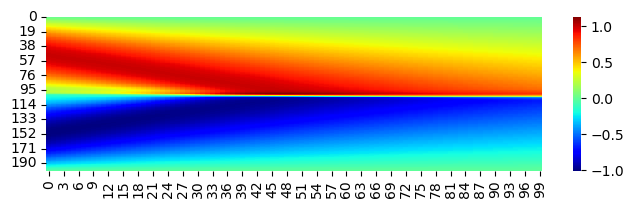

In [47]:


# Evaluating model

h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

# Exact solution = 
X = torch.stack(torch.meshgrid(x, t, indexing = 'ij')).reshape(2, -1).T

model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X).reshape(len(x), len(t)).numpy()

plt.figure(figsize=(8, 2))
sns.heatmap(y_pred, cmap = "jet")
plt.savefig("heatmap.png")